### Aplicando descomposición de valores singulares

Una vez hemos limpiado el dataset de imagenes, deseamos conocer hasta qué punto podríamos reducir la dimensionalidad de las mismas preservando en ellas las secciones más importantes, es decir, que se puedan seguir identificando la distribución de la dentadura, problemas de caries, entre otras afecciones dentales

Dependiendo de los resultados de este análisis podríamos:
- Contar un cojunto de imagenes de menor peso y tamaño lo que nos permitirá probar modelos de clusterización complejos
- Reducir el "ruido" en las imagenes
- Poder visualizarlas de manera eficiente en caso de requerirse

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from pca import pca
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# !pip install tables

Cargamos en un dataframe las imagenes y sus propiedades tras el proceso de limpieza y transformación realizado previamente en 2_Clean_dataset.ipynb.

In [5]:
df = pd.read_hdf('2_Cleaned_dataset/images.h5', key='data')
df.shape

(910, 10)

In [6]:
df.head()

,full_path,main_folder,intermediate_path,file_name,format,height,width,size,bands,image
0,2_Cleaned_dataset\images\1.png,images,images,1.png,PNG,188,398,38377,1,"[[207, 196, 188, 185, 192, 199, 216, 233, 239,..."
1,2_Cleaned_dataset\images\10.png,images,images,10.png,PNG,188,398,36997,1,"[[197, 209, 205, 191, 174, 158, 146, 150, 158,..."
2,2_Cleaned_dataset\images\100.png,images,images,100.png,PNG,188,398,37350,1,"[[164, 158, 141, 148, 157, 154, 172, 183, 186,..."
3,2_Cleaned_dataset\images\100_2812.png,images,images,100_2812.png,PNG,188,398,37226,1,"[[209, 214, 215, 217, 217, 216, 217, 219, 219,..."
4,2_Cleaned_dataset\images\101.png,images,images,101.png,PNG,188,398,36627,1,"[[150, 138, 138, 136, 125, 128, 128, 131, 121,..."


In [26]:
# obtenemos una muestra del dataframe para trabajar un poco más rápido
df_sample = df.sample(n=100)

Graficamos una muestra de las imagenes

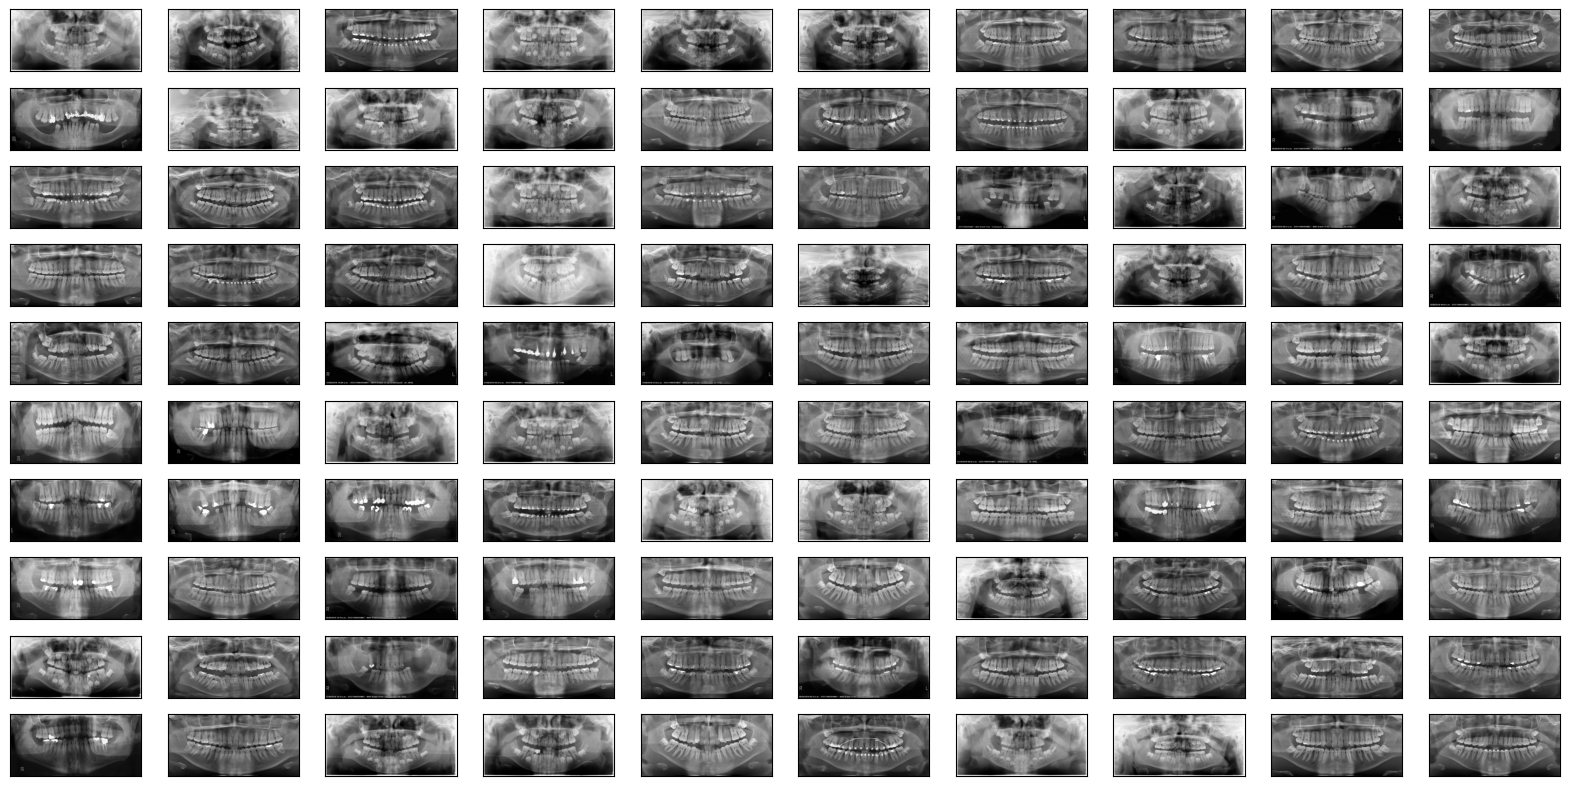

In [29]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow((df_sample[i:i+1]['image'].values[0]), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [30]:
# Aplanamos las imágenes antes de crear una matriz de valores estandarizados
X = np.stack(df['image'].apply(lambda x: x.flatten()))
X.shape

(910, 74824)

In [31]:
# Estandarizamos los datos
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Crea un DataFrame a partir de los datos escalados
X_standardized_df = pd.DataFrame(X_standardized)
X_standardized_df

,0,1,2,3,4,5,6,7,8,9,...,74814,74815,74816,74817,74818,74819,74820,74821,74822,74823
0,0.343527,0.118632,-0.030663,-0.081757,0.080161,0.249434,0.631962,0.988661,1.118684,1.325216,...,-0.841336,-0.844258,-0.847812,-0.854670,-0.862017,-0.873673,-0.891742,-0.918227,-0.953645,-1.017619
1,0.132661,0.390085,0.323863,0.042899,-0.293390,-0.608614,-0.836055,-0.731730,-0.552981,-0.684419,...,-0.680057,-0.672505,-0.687132,-0.683567,-0.680068,-0.680488,-0.697646,-0.722692,-0.745391,-0.807518
2,-0.563199,-0.674846,-1.010824,-0.850467,-0.646189,-0.692326,-0.290792,-0.047719,0.024879,-0.021446,...,-0.830584,-0.833524,-0.815676,-0.801200,-0.797800,-0.787813,-0.816260,-0.907364,-0.898841,-0.752229
3,0.385701,0.494489,0.532408,0.583074,0.598982,0.605210,0.652933,0.698475,0.705927,0.682962,...,-0.615545,-0.608097,-0.612148,-0.619403,-0.594445,-0.551698,-0.481983,-0.266444,-0.043903,0.309330
4,-0.858413,-1.092466,-1.073388,-1.099779,-1.310280,-1.236454,-1.213545,-1.125554,-1.316580,-1.347391,...,-0.841336,-0.844258,-0.847812,-0.854670,-0.862017,-0.873673,-0.891742,-0.918227,-0.953645,-1.017619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,1.355687,1.329729,1.283170,1.268680,1.221567,1.191194,1.198197,1.195937,1.180597,1.200909,...,1.846658,1.860860,1.862318,1.861594,1.856514,1.863115,1.857959,1.851854,1.841345,1.802146
906,1.355687,1.350610,1.345734,1.331008,1.325331,1.337690,1.344998,1.341030,1.325062,1.366652,...,1.846658,1.850125,1.851606,1.861594,1.856514,1.852382,1.857959,1.851854,1.841345,1.802146
907,1.355687,1.350610,1.345734,1.310232,1.304578,1.337690,1.344998,1.341030,1.304424,1.345934,...,1.868162,1.860860,1.851606,1.861594,1.867217,1.863115,1.847176,1.851854,1.841345,1.802146
908,1.355687,1.350610,1.345734,1.331008,1.325331,1.337690,1.324027,1.299575,1.304424,1.304498,...,1.878914,1.871594,1.873030,1.872288,1.867217,1.863115,1.857959,1.851854,1.841345,1.802146


Ahora identificaremos qué tanto podríamos reducir la dimension de las imágenes de manera que aún pueda explicarse entre el 90% y 95% de la varianza.   Nos apoyaremos en el módulo PCA de la librería Scikit-Learn y dada la alta dimensionalidad de las imagenes, realizaremos una primera aproximación de nuestro parámetro de número de componentes, para identificar un rango de valores candidato antes de realizar una busqueda exhaustiva.

In [48]:
# Crear una instancia de PCA con el número deseado de componentes
def get_explained_variance_ratio(n):
    model = PCA(n)
    model.fit_transform(X_standardized_df)
    explained_variance_ratio = model.explained_variance_ratio_
    total_explained_variance = sum(explained_variance_ratio)
    print(f"Porcentaje de varianza explicada para {n} componentes: {total_explained_variance}")

[get_explained_variance_ratio(i) for i in [5, 10, 50, 100, 200, 300, 400]]

Porcentaje de varianza explicada para 5 componentes: 0.5003009891073681
Porcentaje de varianza explicada para 10 componentes: 0.5940590819816953
Porcentaje de varianza explicada para 50 componentes: 0.7724044176525743
Porcentaje de varianza explicada para 100 componentes: 0.8380184206736311
Porcentaje de varianza explicada para 200 componentes: 0.902653693228794
Porcentaje de varianza explicada para 300 componentes: 0.9375181281217204
Porcentaje de varianza explicada para 400 componentes: 0.9596046581147503


[None, None, None, None, None, None, None]

Vemos que con 300 componentes logramos explicar el 93.75% de la varianza, por lo que optamos por tomar este valor

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [74824] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[300]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


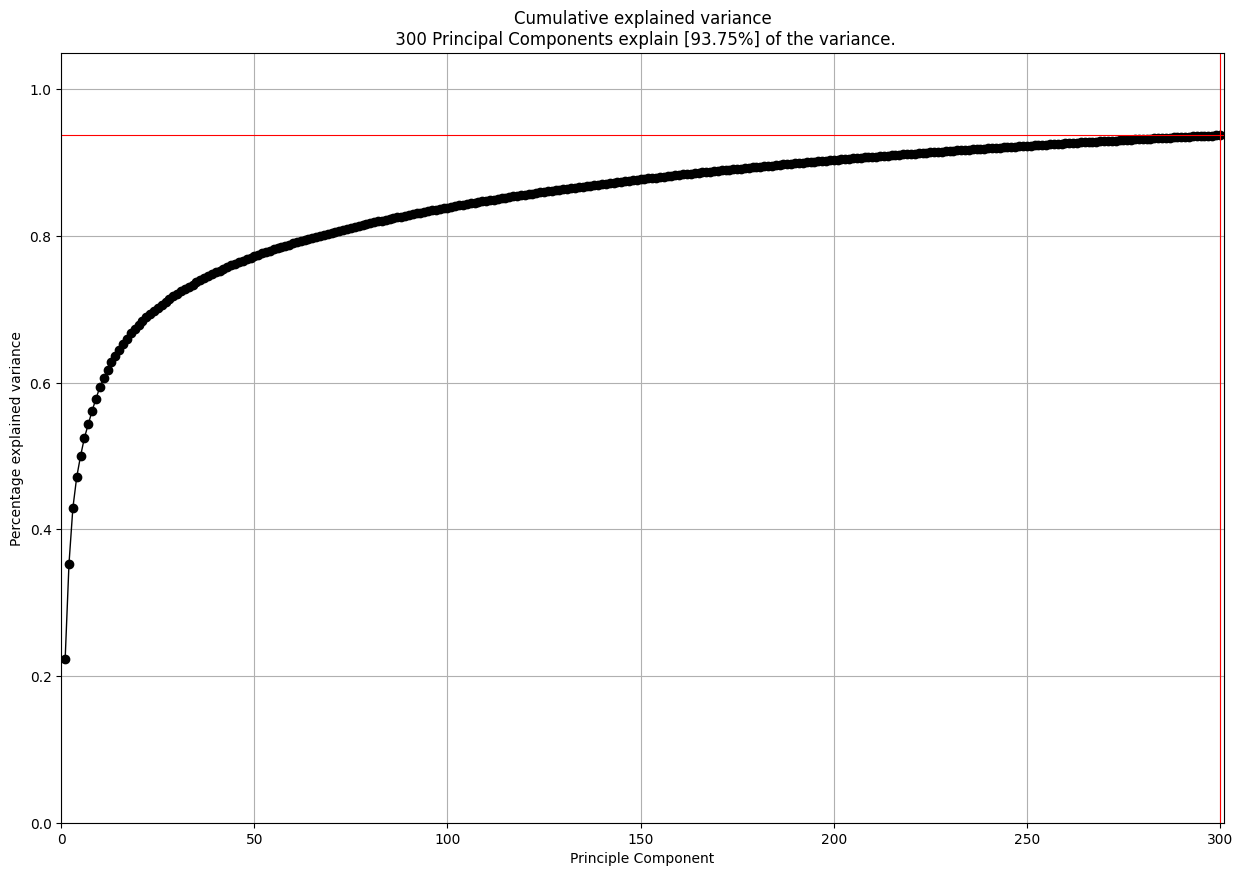

In [50]:
# Gráfica
model = pca(300)
model.fit_transform(X_standardized_df)
fig, ax = model.plot()